In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
%matplotlib nbagg

In [3]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
import libertem.api as lt
import libertem.udf.blobfinder as blb
import libertem.analysis.gridmatching as grm
import libertem.udf.logsum as logsum
# This extra requires hdbscan, which is an optional dependency
import libertem.analysis.fullmatch as fm
import libertem.viz as viz

In [5]:
ctx = lt.Context()

In [6]:
ds = ctx.load(
    'ser',
    path=r'C:/Users/weber/Nextcloud/Projects/Open Pixelated STEM framework/Data/Xiankui/NBED-R3/NBED-R3-map_1.ser'
)

In [7]:
(y, x) = ds.shape.nav
(fy, fx) = ds.shape.sig

In [8]:
# Sum of log-scaled frames, which highlights weak peaks that are present in many frames
logsum_result = logsum.run_logsum(ctx, ds)

In [9]:
peakfind_params = dict(
    radius=10.0,
    padding=1,
    mask_type='radial_gradient',
    num_disks=40
)
# Find peaks in the logsum frame
found_peaks = blb.get_peaks(parameters=peakfind_params, sum_result=logsum_result['logsum'].data)
# Find lattice match for peaks from scratch
# This doesn't take into account the 3D crystal structure of the sample,
# but works puerly within the 2D geometry of the detector
(matches, unmatched, weak) = fm.full_match(found_peaks)

<IPython.core.display.Javascript object>


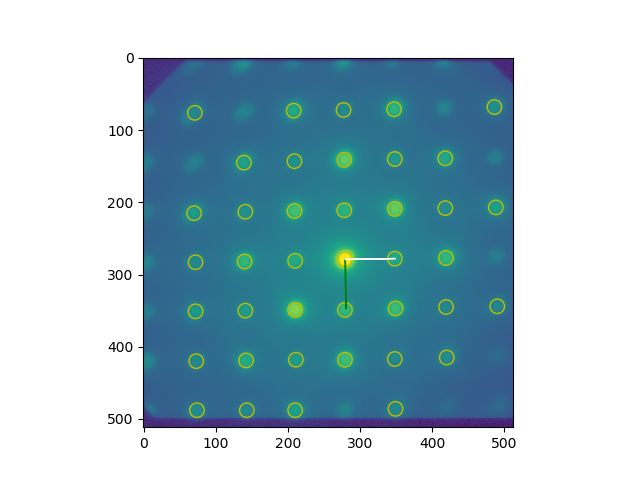

In [10]:
# Visualize found peaks and lattice match
fig, axes = plt.subplots()
axes.imshow(logsum_result['logsum'].data)
m = matches[0]
for p in np.flip(found_peaks, axis=1):
    axes.add_artist(plt.Circle(p, peakfind_params['radius'], color="y", fill=False))
    
plt.arrow(*np.flip(m.zero), *(np.flip(m.a)), color='g')
plt.arrow(*np.flip(m.zero), *(np.flip(m.b)), color='w')

In [11]:
# We cast a wide net and start out with many, many potential peaks
# Generally, this is not limited to peaks that we found in the logsum frame,
# but all equivalent positions within the frame.
# Weak matches are eliminated later
grid = np.mgrid[-10:10, -10:10]

r = peakfind_params['radius']

raw_indices = np.concatenate(grid.T)
raw_peaks = grm.calc_coords(m.zero, m.a, m.b, raw_indices)

peak_selector = grm.within_frame(raw_peaks, r, fy, fx)

# Continue only with the ones within the frame
indices = raw_indices[peak_selector]
peaks = raw_peaks[peak_selector]

corr_params = dict(
    radius=10.0,
    padding=1,
    mask_type='radial_gradient',
    num_disks=len(peaks)
)
match_params = dict()

In [12]:
# Refine the lattice parameters for each frame
match = blb.run_refine(ctx, ds, m.zero, m.a, m.b, indices, corr_params, match_params)

In [13]:
zeros = match['zero'].data.reshape((y, x, 2))
aas = match['a'].data.reshape((y, x, 2))
bbs = match['b'].data.reshape((y, x, 2))

In [14]:
polar_zeros = grm.make_polar(match['zero'].data).reshape((y, x, 2))
polar_aas = grm.make_polar(match['a'].data).reshape((y, x, 2))
polar_bbs = grm.make_polar(match['b'].data).reshape((y, x, 2))

<IPython.core.display.Javascript object>


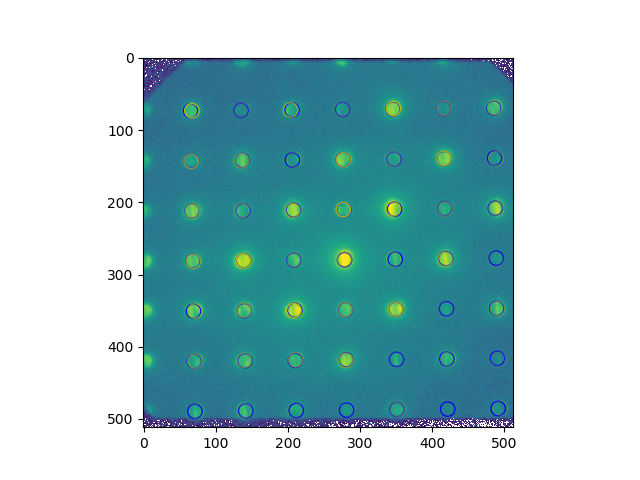

c:\users\weber\appdata\local\conda\conda\envs\libertem\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
c:\users\weber\appdata\local\conda\conda\envs\libertem\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


In [15]:
# Visualize the refinement of a specific frame
fig, axes = plt.subplots()

pick_y = 7
pick_x = 6

index = (pick_y * x + pick_x)

# Get the frame from the dataset
get_sample_frame = ctx.create_pick_analysis(dataset=ds, y=pick_y, x=pick_x)
sample_frame = ctx.run(get_sample_frame)

axes.imshow(np.log(sample_frame[0].raw_data + 1))

sample_refined_fit = match['refineds'].data[index]
sample_elevations = match['peak_elevations'].data[index]
selector = match['selector'].data[index]

max_elevation = np.max(sample_elevations)

# Calclate the best fit positions to compare with the
# individual peak positions.
# A difference between best fit and individual peaks highlights outliers.
calculated = grm.calc_coords(
    zero=match['zero'].data[index],
    a=match['a'].data[index],
    b=match['b'].data[index],
    indices=indices
)

# Plot markers for the calculated positions
for i in range(len(calculated)):
    p = np.flip(calculated[i])
    axes.add_artist(plt.Circle(p, corr_params['radius'], color="b", fill=False))

selected_refined = sample_refined_fit[selector]
selected_elevations = sample_elevations[selector]

# Plot markers for the individual peak positions.
# The alpha channel represents the peak elevation, which is used as a weight in the fit.
for i in range(len(selected_refined)):
    p = np.flip(selected_refined[i])
    a = max(0, selected_elevations[i] / max_elevation)
    axes.add_artist(plt.Circle(p, corr_params['radius'], color="y", fill=False, alpha=a))

# Plot peaks that were eliminated from the fit
# because of position mismatch or low quality
skipped_peaks = calculated[np.invert(selector)]

for i in range(len(skipped_peaks)):
    (yy, xx) = skipped_peaks[i]
    r = corr_params['radius']
    xy = (xx - r, yy - r)
    axes.add_artist(plt.Rectangle(xy, 2*r, 2*r, color="r", fill=False))


<IPython.core.display.Javascript object>


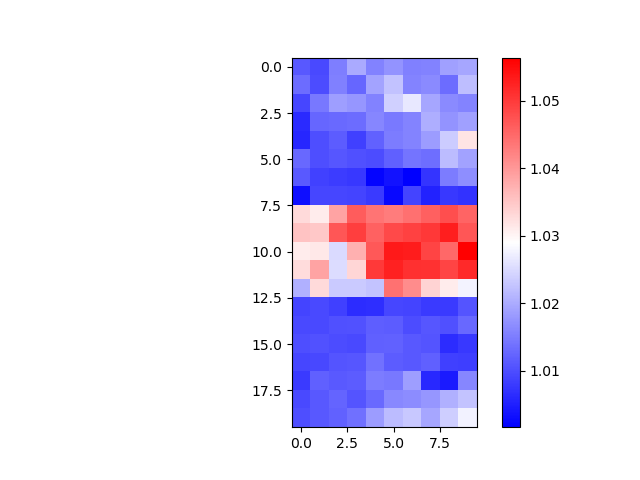

In [16]:
fig, axes = plt.subplots()
# maximum of a/b, b/a to extract "c/a" ratio
plt.imshow(np.maximum(polar_bbs[:,:,0] / polar_aas[:,:,0], polar_aas[:,:,0] / polar_bbs[:,:,0]), cmap=cm.bwr)
plt.colorbar()

<IPython.core.display.Javascript object>


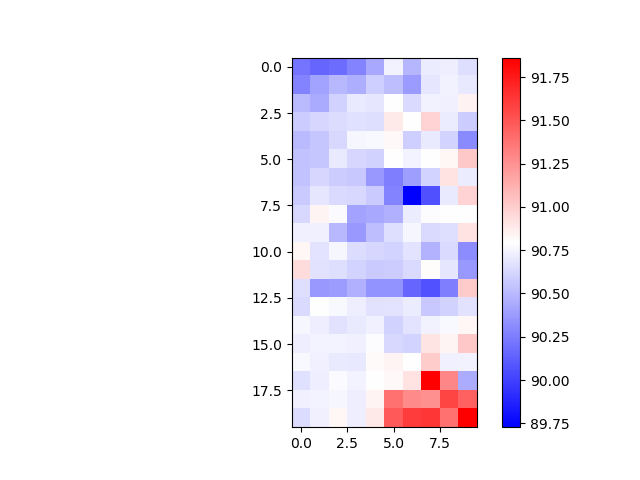

In [17]:
fig, axes = plt.subplots()
# Angle between a and b
plt.imshow((polar_aas[:,:,1] - polar_bbs[:,:,1])*180/np.pi, cmap=cm.bwr)
plt.colorbar()

<IPython.core.display.Javascript object>


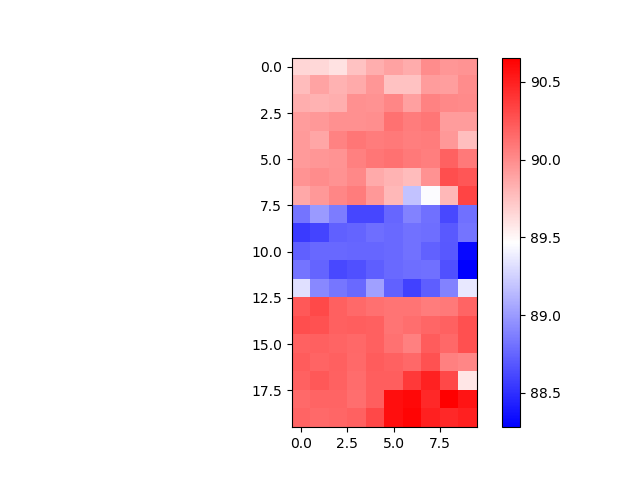

In [18]:
fig, axes = plt.subplots()
# Orientation of "a" vector
plt.imshow(polar_aas[:,:,1]*180/np.pi, cmap=cm.bwr)
plt.colorbar()

<IPython.core.display.Javascript object>


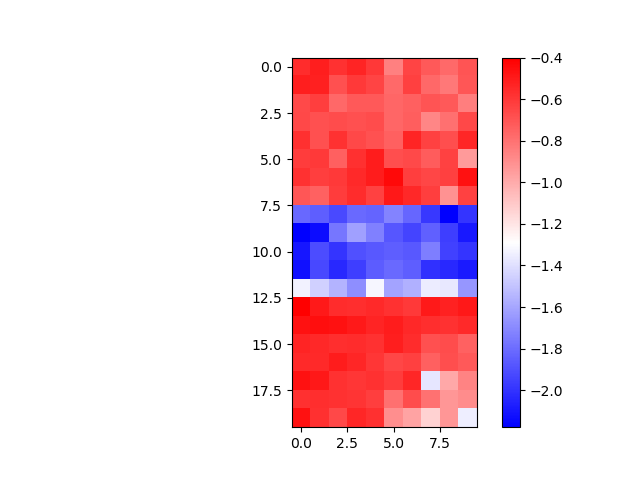

In [19]:
fig, axes = plt.subplots()
plt.imshow(polar_bbs[:,:,1]*180/np.pi, cmap=cm.bwr)
plt.colorbar()

<IPython.core.display.Javascript object>


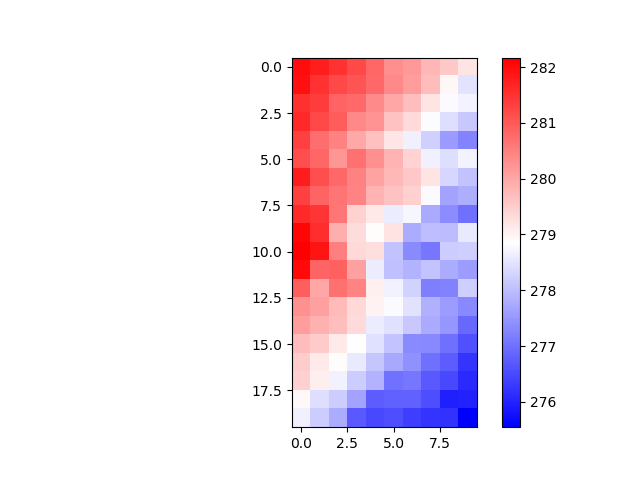

In [20]:
fig, axes = plt.subplots()
# Shift of the y component of the zero point
# Shifts of the zero point might reveal electromagnetic fields under some conditions.
plt.imshow(zeros[:,:,0], cmap=cm.bwr)
plt.colorbar()

In [21]:
# Fit the zero position with a linear gradient to approximate descan error
positions = np.concatenate(np.mgrid[0:x, 0:y].T)
fit_indices = np.hstack([np.ones([len(positions), 1]), positions])
(fit, residuals, rank, s) = np.linalg.lstsq(fit_indices, zeros.reshape(-1, 2), rcond=None)

In [22]:
# Substract best fit linear gradient from zero point positions
gradient = np.dot(fit_indices, fit).reshape(y, x, 2)
diff = zeros - gradient

<IPython.core.display.Javascript object>


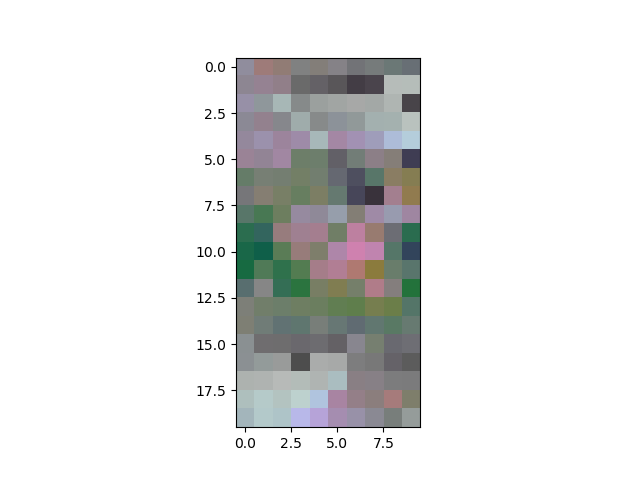

In [23]:
cmap = viz.ColormapCubehelix()
fig, axes = plt.subplots()
# Shift of the zero point visualized with cubehelix 2D color map
plt.imshow(cmap.rgb_from_vector((diff[:, :, 1], diff[:, :, 0])))